In [1]:

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 100)

from matplotlib import pyplot as plt
%matplotlib inline 

import seaborn as sns

# Scikit-Learn for Modeling
import sklearn

# Pickle for saving model files
import pickle

# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Naive Bayes (Gaussian) has been reported as performing well on this dataset
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

# Function for splitting training and test set
from sklearn.model_selection import train_test_split 

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# For standardization
from sklearn.preprocessing import StandardScaler

# Helper for cross-validation
from sklearn.model_selection import GridSearchCV

# Classification metrics (added later)
from sklearn.metrics import roc_curve, auc

# Min-Max scaler (for use with Gaussian Classifiers)
from sklearn.preprocessing import MinMaxScaler

# Box-Cox transformation
from scipy.stats import boxcox

# Used for custom transformers
from sklearn.base import TransformerMixin

# Import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")


In [2]:
class BoxCoxTransformer(TransformerMixin):
    """
    Custom Box-Cox transformer using the TransformerMixin.
    Credit to EliteDataScience for this class.
    """
    
    def __init__(self, lmbda=None):
        # If lambda values were passed in during initialization, use those
        self.lmbda = lmbda
        
    def transform(self, X, *_):   
        # If given a 1-dimensional X, reshape it to have 2 dimensions
        if len(X.shape) == 1:
            X = X.values.reshape(-1,1)
        
        # Create empty output list
        output = []
        
        # For each feature...
        for i in range(X.shape[1]):
            # Transform that feature's data using its corresponding lambda value
            X_transformed = boxcox(X[:, i], self.lmbda[i])
            
            # Append to output list
            output.append(X_transformed)
        
        # Make output list a Numpy array and transpose it
        output = np.array(output).transpose()
        
        return output
    
    def fit(self, X, *_):
        # If given a 1-dimensional X, reshape it to have 2 dimensions
        if len(X.shape) == 1:
            X = X.values.reshape(-1,1)

        # Create empty lambda list
        self.lmbda = []
        
        # For each feature...
        for i in range(X.shape[1]):
            # Find the best lambda for transforming that feature
            X_transformed, lmbda = boxcox(X[:, i])
            
            # Append that lambda to the lambda list
            self.lmbda.append(lmbda)
            
        return self

This is a classification task. We are trying to predict which loans will default.
Here we follow a standard ML workflow. We split our data into train and tet sets and will parametrize and test the performance of 4 classification algorithms. The 4 algorithms used will be :
* Regularized L1 logistic regression  - penalize the absolute size of model coefficients.
* Regularized L2 logistic regresion -  penalize the squared size of model coefficients.
* Random Forest Classifier
* Gradient Boosting Classifier

The model will give us a probability of whether a loan will default or not.

In [3]:
# Load analytical base table 
df = pd.read_csv('lc_analytical_base_table.csv', low_memory=False)

In [4]:
# Create separate object for target variable
y = df["loan_status"]

# Create separate object for input features
X = df.drop("loan_status", axis=1)

We will split the train/test set 80/20.  We also stratify to ensure the target feature is balanced in each subset of data.

In [5]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234,
                                                    stratify=df["loan_status"])

# Print number of observations in X_train, X_test, y_train, and y_test
print( len(X_train), len(X_test), len(y_train), len(y_test) )


59127 14782 59127 14782


In [6]:
y_train.mean()

0.28338999103624402

In this sample c. 28% of the loans are either charged-off or over 31 days late

We will use 4 classification algorithms, create pipelines for each and set algorithm hyperparameters.
Note that we standardize the feature values but subtracting means and dividing by standard deviation across the feature set. We will also create 2 naive Bayes classifier piupelines for comparison. Note that the Bayes pipelines require positive values and a Box Cox Transformer is used instead.

In [7]:
pipelines = {
    'l1' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l1' , random_state=123)),
    'l2' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l2' , random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123)),
    'gnb' : make_pipeline(MinMaxScaler(feature_range=(1,2)), BoxCoxTransformer(), GaussianNB()),
    'bnb' : make_pipeline(MinMaxScaler(feature_range=(1,2)), BoxCoxTransformer(),BernoulliNB())
}


In [8]:
np.linspace(1e-3, 1e3, 10)

array([1.00000e-03, 1.11112e+02, 2.22223e+02, 3.33334e+02, 4.44445e+02,
       5.55556e+02, 6.66667e+02, 7.77778e+02, 8.88889e+02, 1.00000e+03])

we will test a range of penalties from 0.001 to 1000 for the l1 and l2 algorithms. We also use popular values for RF and GB hyperparameter arguments.

In [8]:
# Logistic Regression hyperparameters
l1_hyperparameters = {'logisticregression__C' : np.linspace(1e-3, 1e3, 10),}
l2_hyperparameters = {'logisticregression__C' : np.linspace(1e-3, 1e3, 10),}

# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [20, 40],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.5],
    'randomforestclassifier__min_samples_leaf': [1,3]
}
#Gradient Boosting hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [20, 40],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2, 0.3],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

In [9]:
gnb_hyperparameters = {}
bnb_hyperparameters = {}

In [10]:

hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'gnb': gnb_hyperparameters,
    'bnb': bnb_hyperparameters
}


Use cross validation to tune each model. Here we use 10 fold cross-validation - i.e., we iteratively create 9 folds plus 1 hold-out fold and will average the training score over the 10 hold-out folds. 

In [11]:
fitted_models = {}
#algs_to_test = ['l1', 'l2', 'rf', 'gb','gnb', 'bnb']
algs_to_test = ['l1','rf', 'gb']

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    if name in algs_to_test:
        model.fit(X_train, y_train)
        fitted_models[name] = model
        print(name, 'has been fitted.')

l1 has been fitted.
rf has been fitted.
gb has been fitted.


Let's look at the holdout accuracy scores. This is the percent of observations correctly classified by the models. Note that our data is heavily imbalanced with over 70% target values equal to loan paid.
Holdout accuracy scores are not robust to imbalanced data sets.

In [12]:
for name, model in fitted_models.items():
    print( name, model.best_score_ )

l1 0.736431748609
rf 0.734588259171
gb 0.738630405737


Note that each of these models can be used to give us a predicted probability for default or fully paid for every entry in the test data set. To evaluate in more detail the performance of the algorithms we compare the predicted probabilities.

In [13]:
# Generate the predicted probabilities from our fitted models on the test data
pred_dict = {}

if 'l1' in algs_to_test:
    pred_l1 = fitted_models['l1'].predict(X_test)
    prob_l1 = fitted_models['l1'].predict_proba(X_test)
    pred_dict['pred_l1'] = pred_l1
    pred_dict['prob_l1'] = prob_l1
    
if 'l2' in algs_to_test:
    pred_l2 = fitted_models['l2'].predict(X_test)
    prob_l2 = fitted_models['l2'].predict_proba(X_test)
    pred_dict['pred_l2'] = pred_l2
    pred_dict['prob_l2'] = prob_l2
    
if 'rf' in algs_to_test:
    pred_rf = fitted_models['rf'].predict(X_test)
    prob_rf = fitted_models['rf'].predict_proba(X_test)
    pred_dict['pred_rf'] = pred_rf
    pred_dict['prob_rf'] = prob_rf
    
if 'gb' in algs_to_test:
    pred_gb = fitted_models['gb'].predict(X_test)
    prob_gb = fitted_models['gb'].predict_proba(X_test)
    pred_dict['pred_gb'] = pred_gb
    pred_dict['prob_gb'] = prob_gb
    
if 'gnb' in algs_to_test:
    pred_gnb = fitted_models['gnb'].predict(X_test)
    prob_gnb = fitted_models['gnb'].predict_proba(X_test)
    pred_dict['pred_gnb'] =pred_gnb
    pred_dict['prob_gnb'] = prob_gnb
    
if 'bnb' in algs_to_test:
    pred_bnb = fitted_models['bnb'].predict(X_test)
    prob_gnb = fitted_models['gnb'].predict_proba(X_test)
    pred_dict['pred_bnb'] = pred_bnb
    pred_dict['prob_bnb'] = prob_bnb


GB has the highest fit against the trraining data so lets look at its performance in some more detail.

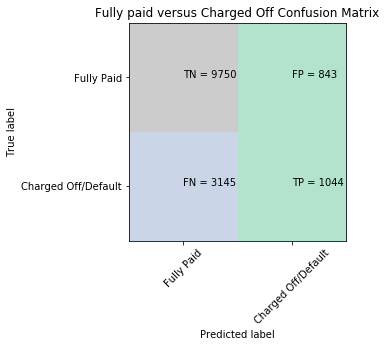

In [14]:
cm = confusion_matrix(y_test, pred_dict['pred_gb'])
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel2)
classNames = ['Fully Paid','Charged Off/Default']
plt.title('Fully paid versus Charged Off Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [15]:
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]

print("True Negatives: ", TN, "Correctly predicted \"Fully Paid\" Loans")
print("False Positives: ", FP, "Incorrectly predicted as \"Default\"" )
print("False Negatives: ", FN, "Incorrectly predicted as \"Fully Paid\"")
print("True Positives: ", TP, "Correctly predicted as \"Default\"")

True Negatives:  9750 Correctly predicted "Fully Paid" Loans
False Positives:  843 Incorrectly predicted as "Default"
False Negatives:  3145 Incorrectly predicted as "Fully Paid"
True Positives:  1044 Correctly predicted as "Default"


In [60]:
print(classification_report(y_test, pred_dict['pred_gb']))


             precision    recall  f1-score   support

          0       0.79      0.98      0.88      3116
          1       0.60      0.09      0.16       884

avg / total       0.75      0.79      0.72      4000



The sklearn documentation defines these valuesas follows:
The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F1 score can be interpreted as a weighted harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

The support is the number of occurrences of each class in y_pred.

The precision and recall scores are poor for the charged-off loans.The last metric we will examine here is the ROC curve = Reciever Operating Characteristic plot. It is a way to visualize the relationship between TPR and FPR for classification models. It plots the true positive rate and false positive rate at different classification probability thresholds.

As well as returning binary classifications of 0,1, for loan paid or charged-off respectively, we can also look at the probability or confidence in each loan classiciation prediction.

In [41]:
pred_dict['prob_gb']

array([[0.76973485, 0.23026515],
       [0.71761905, 0.28238095],
       [0.81261905, 0.18738095],
       ...,
       [0.77361111, 0.22638889],
       [0.77333333, 0.22666667],
       [0.93333333, 0.06666667]])

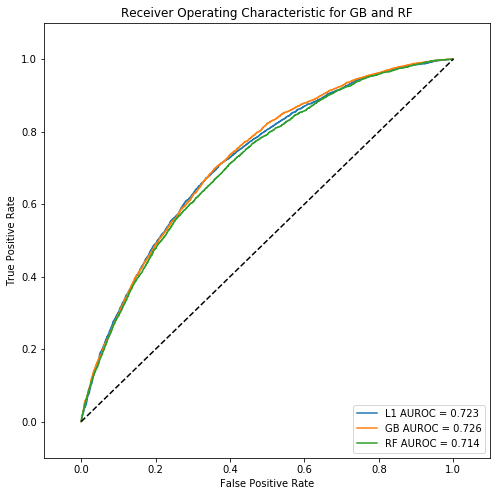

In [16]:
# Initialize plot
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic for GB and RF')

# ---- L1 ---- #

# Calculate ROC curve from y_test and the predicted probabilities for charged-off loans using the L1 algorithm.
#The list comprehension below here returns the probabilities associated with charged-off predictions.
fpr, tpr, thresholds = roc_curve(y_test, [p[1] for p in pred_dict['prob_l1']])

# Calculates AUROC
auroc = round(auc(fpr, tpr), 3)
    
# Plots ROC curve and labels with AUROC
plt.plot(fpr, tpr, label='{} AUROC = {}'.format('L1', auroc))


# ---- Gradient Boosting ---- #

# Calculate ROC curve from y_test and the predicted probabilities for charged-off loans using the gb algorithm.
#The list comprehension below here returns the probabilities associated with charged-off predictions.
fpr, tpr, thresholds = roc_curve(y_test, [p[1] for p in pred_dict['prob_gb']])

# Calculates AUROC
auroc = round(auc(fpr, tpr), 3)
    
# Plots ROC curve and labels with AUROC
plt.plot(fpr, tpr, label='{} AUROC = {}'.format('GB', auroc))


# ---- Random Forest ---- #

fpr, tpr, thresholds = roc_curve(y_test, [p[1] for p in pred_dict['prob_rf']])

    
# Calculates AUROC
auroc = round(auc(fpr, tpr), 3)
    
# Plots ROC curve and labels with AUROC
plt.plot(fpr, tpr, label='{} AUROC = {}'.format('RF', auroc))


# ---- Legend and labels ---- #

# Plot legend
plt.legend(loc='lower right')

# Plots 45 degree dotted black line
plt.plot([0,1],[0,1],'k--', label='random guess')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


The AUROC metric is robust against imbalanced classes and tells us the the likelihood that our model can distinguish between a randomly chosen loan that will default versus a randomly chosen loan that will not default.

Confusion Matrix Revisited.
This model would be used to predict the likelihood of loan default.
Assuming investor are risk-adverse and would prefer to refuse potentially good loans rather than suffer defaults then we can alter the classification threshold to reduce the number of False Negatves, i.e., those loans that we incorrectly predict to be fully paid.
The code below shows that lowering the clasification threshold to 0.3 reduces the number of false psitives by c. 50% 

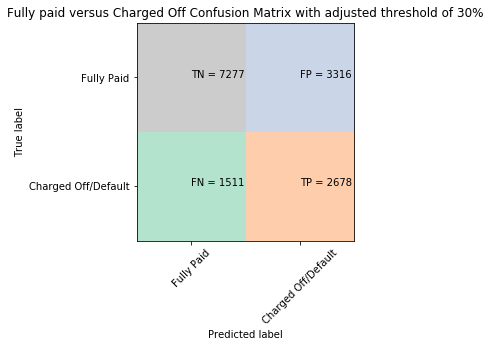

In [19]:
# get prediction probabilities associated with the GB model
pred_probs = [p[1] for p in pred_dict['prob_gb']]
threshold = 0.3
              
#adjusts class predictions based on the prediction threshold (t).
adjusted_preds = [1 if p >= threshold else 0 for p in pred_probs]

cm = confusion_matrix(y_test, adjusted_preds)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel2)
classNames = ['Fully Paid','Charged Off/Default']
plt.title('Fully paid versus Charged Off Confusion Matrix with adjusted threshold of 30%')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [20]:
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]
print("Using adjusted classifiation probability threshold: ", threshold)
print("True Negatives: ", TN, "Correctly predicted \"Fully Paid\" Loans")
print("False Positives: ", FP, "Incorrectly predicted as \"Default\"" )
print("False Negatives: ", FN, "Incorrectly predicted as \"Fully Paid\"")
print("True Positives: ", TP, "Correctly predicted as \"Default\"")

Using adjusted classifiation probability threshold:  0.3
True Negatives:  7277 Correctly predicted "Fully Paid" Loans
False Positives:  3316 Incorrectly predicted as "Default"
False Negatives:  1511 Incorrectly predicted as "Fully Paid"
True Positives:  2678 Correctly predicted as "Default"


In [18]:
# Save winning model as final_model.pkl
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['gb'].best_estimator_, f)